<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="https://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/llibre-estil/logo-UOC-masterbrand-vertical.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.883 · Aprendizaje por refuerzo</p>
<p style="margin: 0; text-align:right;">2023-1 · Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-bottom: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# PEC2: Deep Reinforcement Learning


En esta práctica se implementarán - modelos de DRL en dos entornos diferentes, con el objetivo de analizar distintas formas de aprendizaje de un agente y estudiar su rendimiento. El agente será entrenado con los métodos:

<ol>
    <li>DQN</li>
    <li>Dueling DQN</li>
</ol>
  

**Importante: La entrega debe hacerse en formato notebook y en formato html donde se vea el código y los resultados y comentarios de cada ejercicio. Para exportar el notebook a html puede hacerse desde el menú File  →  Download as  →  HTML.**

## 0. Contexto

El aprendizaje por refuerzo es un campo de la inteligencia artificial que busca desarrollar sistemas capaces de aprender y tomar decisiones autónomas a través de la interacción con su entorno. A lo largo de los años, este enfoque ha demostrado su capacidad para abordar una amplia gama de aplicaciones, desde juegos de mesa hasta robótica y gestión de recursos. Sin embargo, una de las cuestiones más desafiantes en el aprendizaje por refuerzo es la creación de entornos de simulación adecuados que reflejen fielmente el contexto de la aplicación deseada.

En este contexto, esta PEC tiene como objetivo desarrollar un nuevo entorno de simulación que permita la investigación y experimentación con diferentes agentes de trading. Este entorno estará diseñado específicamente para abordar un problema ficticio de inversión y gestión de un portafolio en el mercado de valores, en el que un agente debe aprender a tomar decisiones óptimas de compra, venta o mantenimiento de acciones. El objetivo del agente será maximizar las ganancias a lo largo del tiempo mediante estrategias basadas en el aprendizaje por refuerzo.

Para ello, se utilizará el entorno adaptado a las especificaciones de Gymnasium (https://gymnasium.farama.org/index.html), que permite la creación de entornos personalizados para el aprendizaje por refuerzo. Este entorno simulará el comportamiento dinámico de un mercado financiero, con fluctuaciones en los precios de las acciones y eventos de mercado que afecten las decisiones del agente.


## 1. Creación de un entorno en Gym (3 ptos)

En este ejercicio diseñaremos un entorno sencillo siguiendo el esquema de los entornos de <code>Gymnasium</code>, y trataremos de resolverlo.

Los entornos de <code>Gymnasium</code> suelen tener la siguiente estructura:

```
class FooEnv(gym.Env):
  metadata = {'render.modes': ['human']}

  def __init__(self):
    ...
  def step(self, action):
    ...
    return new_state, reward, terminated, truncated, info

  def reset(self):
    ...
    return observation, info

  def render(self, mode='human', close=False):
    ...

 ```


El primer paso será instalar las librerías necesarias para abordar la PEC:


In [598]:
# !pip install gymnasium
# !pip install torch
# 
# !pip install matplotlib
# !pip install numpy
# !pip install tensorboard
# !pip install tdqm
# !pip install tabulate
# !pip install yfinance
# !pip install pandas

y las importamos:

In [599]:
import numpy as np
import gymnasium as gym
import random
import matplotlib.pyplot as plt
from gymnasium.spaces import Discrete, Box
from collections import namedtuple, deque
from copy import deepcopy
import math
import time
import torch
import torch.nn.functional as F
from tabulate import tabulate
import pandas as pd
import yfinance as yf
import warnings


warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

print("Gym Version:", gym.__version__)  # 0.28.1
print("Gym Version:", torch.__version__)  # 0.28.1

Gym Version: 1.0.0
Gym Version: 2.2.2



###  1.1 Entorno de Simulación para Trading Automático en el Mercado de Valores

***¡Enhorabuena!*** Una firma de inversión ha decidido contrataros para desarrollar un sistema de trading automático para sus operaciones en el mercado de valores. Para ello, os piden que diseñéis un entorno de simulación que permita entrenar un agente capaz de tomar decisiones de compra, venta o mantener posiciones sobre una acción determinada, maximizando las ganancias a lo largo del tiempo. El entorno debe cumplir las siguientes especificaciones:

<ul>
  <li>El entorno debe llamarse <code>StockMarketEnv</code>
  </li>
  <li>El entorno debe heredar de la clase <code>gym.Env</code>
  </li>
  <li>El precio inicial de la acción estará basado en datos históricos, obtenidos a partir de una consulta a Yahoo Finance.</li>
  <li>El balance inicial del agente será de 10,000 dolares, el cual puede ser utilizado para comprar acciones.</li>
  <li>El agente puede realizar las siguientes acciones: </li>
  
  <ul>
    <li>0 -> Mantener (no se realizan operaciones)</li>
    <li>1 -> Comprar (se compra todas las acciones posibles al precio actual)</li>
    <li>2 -> Vender (se vende todas las acciones disponibles al precio actual)</li>
  </ul>
  <li>El sistema de recompensas será el siguiente:</li>
  <ul>
    <li>El agente recibe una recompensa +1 si el valor neto de su portafolio (balance_actual + balance_anterior) aumenta respecto al paso anterior.</li>
    <li>El agente recibe una recompensa de +1 si el valor neto de su portafolio (balance_actual) se mantiene igual, no posee ninguna acción y el valor de las acciones disminuye. Dicha comprobación no se realiza el primer dia de trading.</li>
    <li>El agente recibe una recompensa de -1 si el valor neto de su portafolio (balance_actual) se mantiene igual, no posee ninguna acción y el valor de las acciones aumenta con respecto al día anterior. Dicha comprobación no se realiza el primer dia de trading. </li>
    <li>Si el valor neto disminuye con respecto al día anterior, el agente recibe una recompensa -1.</li>
    <li>En otros casos recibe una puntuación de 0.</li>
  </ul>
  <li>El entorno tendrá una duración por defecto para el entrenamiento 2019-01-01 hasta 2021-01-01 para el entrenamiento.</li>
  <li>El entorno finalizará si el valor neto del portafolio cae por debajo del 85% del balance inicial (es decir, 8,500 dolares ).</li>
</ul>


El objetivo de este entorno es que el agente aprenda a tomar decisiones óptimas de compra y venta.


![Imagen de Stock Market](https://media1.tenor.com/m/wWvt6qEQB8EAAAAd/kah.gif)

#### 1.1.1 Implementación de los indicadores económicos

El primer paso es implementar dos funciones llamadas `calculate_rsi` y `calculate_ema` que calcularán diferentes indicadores técnicos utilizados en el análisis de mercados financieros. Estos indicadores ayudarán a los agentes de trading a tomar decisiones basadas en patrones y tendencias del mercado.

A continuación, se explica en qué consisten estas métricas:

*  RSI (Índice de Fuerza Relativa): Calcula el RSI utilizando el cambio de precio durante una ventana de tiempo especificada. Este indicador muestra si un activo está sobrecomprado o sobrevendido. Podéis ver una explicación más detallada en https://es.wikipedia.org/wiki/%C3%8Dndice_de_fuerza_relativa
*  EMA (Media Móvil Exponencial): Calcula la EMA, que es una versión ponderada de la media móvil que da más peso a los precios recientes. Podéis ver una explicación más detallada en https://es.tradingview.com/support/solutions/43000592270/

Las funciones toman algunos de estos argumentos:

* data: Los datos históricos de precios de las acciones, generalmente en formato de series temporales. En este ejemplo utilizaremos los precios de cierre diarios.
* window (opcional): El número de periodos a utilizar para los cálculos de indicadores. Por defecto, se asume un valor de 14 para el RSI y la EMA.

A continuación, se muestran las funciónes:

In [600]:
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi.fillna(50).squeeze()

def calculate_ema(data, window=14):
    return data.ewm(span=window, adjust=False).mean().squeeze()


Con estas funciones, los agentes podrán utilizar información técnica clave sobre las acciones en el mercado para tomar decisiones de trading más informadas.

Ahora bien, necesitamos el valor de las acciones. Para este proyecto, utilizamos la librería yfinance, que permite la obtención de datos históricos de activos financieros de manera sencilla. El siguiente fragmento de código descarga los datos del ETF SPY (un fondo que sigue al índice S&P 500) desde el 1 de enero de 2021 hasta el 1 de enero de 2022:

In [601]:
data = yf.download("SPY", start="2021-01-01", end="2022-01-01")

print(data)


[*********************100%***********************]  1 of 1 completed

Price      Adj Close     Close      High       Low      Open     Volume
Ticker           SPY       SPY       SPY       SPY       SPY        SPY
Date                                                                   
2021-01-04 349.47168 368.79001 375.45001 364.82001 375.31000  110210800
2021-01-05 351.87863 371.32999 372.50000 368.04999 368.10001   66426200
2021-01-06 353.98227 373.54999 376.98001 369.12000 369.70999  107997700
2021-01-07 359.24161 379.10001 379.89999 375.91000 376.10001   68766800
2021-01-08 361.28845 381.26001 381.48999 377.10001 380.59000   71677200
...              ...       ...       ...       ...       ...        ...
2021-12-27 458.28818 477.26001 477.31000 472.01001 472.06000   56808600
2021-12-28 457.91370 476.87000 478.81000 476.06000 477.72000   47274600
2021-12-29 458.49945 477.48001 478.56000 475.92001 476.98001   54503000
2021-12-30 457.23190 476.16000 479.00000 475.67001 477.92999   55329000
2021-12-31 456.07959 474.95999 476.85999 474.67001 475.64001   6

El resultado es un DataFrame que contiene la siguiente información para cada día del rango de fechas:

- **Open**: Precio de apertura del activo.
- **High**: Precio máximo del activo en el día.
- **Low**: Precio mínimo del activo en el día.
- **Close**: Precio de cierre del activo.
- **Adj Close**: Precio ajustado que tiene en cuenta dividendos y splits.
- **Volume**: Número de acciones negociadas.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio 1 (0.25 ptos):</strong>
    Utiliza los datos históricos del mercado financiero, descargados mediante la función <code>yfinance.download</code>, y aplica los indicadores técnicos proporcionados: <code>calculate_rsi</code> y  <code>calculate_ema</code>
    A continuación, realiza las siguientes tareas:
    <ul>
        <li>Descarga los datos históricos de SPY para el año 2021.</li>
        <li>Calcula el RSI para los precios de cierre durante el período.</li>
        <li>Calcula la media móvil exponencial (EMA) para el mismo período  con los precios de cierre.</li>
        <li>Imprime el último valor de los cálculos de cada indicador (RSI y EMA ) para verificar que se han generado correctamente sin errores. Los valores obtenidos deberían ser RSI: 53.765164 i EMA: 470.690088 (el número de decimales puede variar).</li>
    </ul>

In [602]:
data_2021 = yf.download("SPY", start="2021-01-01", end="2022-01-01")
rsi_2021_close = calculate_rsi(data_2021["Close"])
ema_2021_close = calculate_ema(data_2021["Close"])

print("RSI 2021 close:")
print(rsi_2021_close[-1])
print("\nEMA 2021 close:")
print(ema_2021_close[-1])

[*********************100%***********************]  1 of 1 completed

RSI 2021 close:
53.76516415158352

EMA 2021 close:
470.6900882953319


#### 1.1.2 Implementación de StockMarketEnv

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio 2 (2.25 ptos):</strong> Define el entorno <code>StockMarketEnv</code> siguiendo las indicaciones aportadas anteriormente. Además, a parte de las típicas funciones de cualquier entorno (<code>reset</code>, <code>step</code> y <code>render</code>), deben implementarse dos funciones más (<code>save_to_csv_file</code> y <code>_normalize</code>) que se explican a continuación:
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
   
</div>

##### Crear la función <code>save_to_csv_file</code> en Python
Además, implementa una función <code>save_to_csv_file</code> que guarde los datos actuales de una clase en un archivo CSV. La función calculará el beneficio (profit) como la diferencia entre el valor neto actual (net_worth-> balance efectivo + valor acciones en posesión) y el balance inicial (initial_balance), y escribirá una nueva fila con los valores de current_step, balance, shares_held, net_worth y profit en el archivo CSV.


In [603]:
def save_to_csv_file():
    pass

##### Crear la función de normalización en Python

La función `_normalize` se utiliza para ajustar un valor a un rango estándar, comúnmente entre 0 y 1, en relación a un valor mínimo y máximo especificados. Este proceso, conocido como **normalización**, es útil para transformar datos, manteniendo sus proporciones relativas, dentro de un intervalo más manejable. La función toma tres parámetros:

- `value`: el valor a normalizar.
- `min_val`: el límite inferior del rango de normalización.
- `max_val`: el límite superior del rango de normalización.

La normalización se realiza mediante la siguiente fórmula:

$$
\text{normalized_value} = \frac{\text{value} - \text{min_val}}{\text{max_val} - \text{min_val}}
$$


Este cálculo ajusta `value` al rango definido entre `min_val` y `max_val`. Además, si `max_val` y `min_val` son iguales, la función devuelve `0` para evitar una **división por cero**.

##### Beneficios en el Contexto de Aprendizaje por Refuerzo (RL)

En un entorno de **aprendizaje por refuerzo (RL)**, la normalización es fundamental por varias razones:

1. **Estabilidad de Entrenamiento**: Al normalizar las recompensas, las observaciones o las acciones a un rango estándar, se evita que valores grandes desestabilicen el proceso de aprendizaje. Modelos de RL, como las redes neuronales, tienden a aprender mejor con datos en intervalos limitados.

2. **Facilita la Comparación**: Normalizar permite comparar datos provenientes de distintas fuentes o escalas, como recompensas de diferentes entornos, lo cual mejora la generalización del modelo.

3. **Acelera la Convergencia**: Datos escalados de manera uniforme ayudan a que los algoritmos de RL converjan más rápidamente, ya que se reduce la variabilidad de las entradas.

4. **Previene Errores de Cálculo**: Al manejar entradas normalizadas y con límites definidos, se evitan errores de cálculo o inestabilidades debidas a diferencias numéricas extremas.

------
<b>Nota</b>: se os proporciona el código pre-implementado. La implementación que se pide en el enunciado está indicada en los bloques <i>#TODO</i> y/o con variables igualadas a <i>None</i>.

In [604]:
import os
import csv

start = "2019-01-01"
end = "2021-01-01"
ticker = "SPY"
initial_balance = 10_000

class StockMarketEnv(gym.Env):
    def __init__(
            self, 
            ticker=ticker, 
            initial_balance=initial_balance,  
            is_eval = False,
            start = start,
            end = end,
            save_to_csv=False,
            csv_filename="stock_trading_log.csv"
    ):
        super(StockMarketEnv, self).__init__()

        # Descargar los datos históricos de la acción
        self.df = yf.download(ticker, start, end)
        self.num_trading_days = len(self.df)
        self.prices = self.df.Close.values
        self.n_steps = len(self.prices)-1

        # Parámetros del entorno
        self.initial_balance = initial_balance
        self.current_step = 0
        self.balance = initial_balance
        self.shares_held = 0
        self.net_worth = initial_balance
        self.previus_net_worth = initial_balance

        # Espacio de acciones: 0 -> mantener, 1 -> comprar, 2 -> vender
        self.action_space = gym.spaces.Discrete(3)

        # Calculamos los indicadores técnicos
        self.rsi = calculate_rsi(self.df.Close).values
        self.ema = calculate_ema(self.df.Close).values


        # Espacio de observaciones: [precio_actual, balance, acciones, rsi, ema, sma, upper_band, lower_band]
        self.observation_space = gym.spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(5,),  # 5 features: price, balance, shares, rsi, ema
            dtype=np.float32
        )
        self.is_eval = is_eval

        # Valores para normalización (obtenemos mínimos y máximos)
        self.min_price = self.prices.min()
        self.max_price = self.prices.max()
        self.min_rsi = self.rsi.min()
        self.max_rsi = self.rsi.max()
        self.min_ema = self.ema.min()
        self.max_ema = self.ema.max()


        # Parámetros adicionales para el CSV
        self.save_to_csv = save_to_csv
        self.csv_filename = csv_filename

        # Si la opción de almacenar en CSV está activada, crea o sobreescribe el archivo
        if self.save_to_csv:
            pass

    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        self.net_worth = self.initial_balance
        self.previus_net_worth = self.initial_balance
        
        if seed is not None:
            super().reset(seed=seed)
        
        return self._next_observation(), {}

    def _normalize(self, value, min_val, max_val):
        return (value - min_val) / (max_val - min_val)

    def _next_observation(self):
        # Normalizamos los valores
        current_price = self.prices[self.current_step][0]
        norm_price = self._normalize(current_price, self.min_price, self.max_price)
        norm_balance = self._normalize(self.balance, self.initial_balance * 0.85, self.initial_balance * 1.25)
        norm_shares_held = self._normalize(self.shares_held, 0, 100)  # Máximo de 100 acciones
        norm_rsi = self._normalize(self.rsi[self.current_step], self.min_rsi, self.max_rsi)
        norm_ema = self._normalize(self.ema[self.current_step], self.min_ema, self.max_ema)

        return np.array([
            norm_price,
            norm_balance,
            norm_shares_held,
            norm_rsi,
            norm_ema,
        ])


    def step(self, action):
        current_price = self.prices[self.current_step][0]
        self.previus_net_worth = self.net_worth

        if action == 1:  # Buy
            max_shares_possible = self.balance // current_price
            shares_to_buy = max_shares_possible
            
            purchase_cost = shares_to_buy * current_price
            self.balance -= purchase_cost
            self.shares_held += shares_to_buy
            
        elif action == 2:  # Sell
            sale_value = self.shares_held * current_price
            self.balance += sale_value
            self.shares_held = 0

        self.net_worth = self.balance + (self.shares_held * current_price)
        
        step_reward = self.net_worth - self.previus_net_worth
        
        self.current_step += 1
        
        is_terminated = self.current_step >= self.n_steps
        is_truncated = self.net_worth < (self.initial_balance * 0.85) 
        
        if self.save_to_csv:
            self.save_to_csv_file()
        
        obs = self._next_observation()
        
        info = {
            'current_price': current_price,
            'net_worth': self.net_worth,
            'balance': self.balance,
            'shares_held': self.shares_held,
        }
        
        return obs, step_reward, is_terminated, is_truncated, info

    def render(self, mode='human'):
        profit = self.net_worth - self.initial_balance
        
        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance:.2f}')
        print(f'Shares held: {self.shares_held}')
        print(f'Net worth: {self.net_worth:.2f}')
        print(f'Profit: {profit:.2f}')
        print('-' * 30)

    # La función save_to_csv_file guarda los datos actuales en un archivo CSV.
    # 1. Primero calcula el beneficio como la diferencia entre el valor neto
    # actual y el balance inicial.
    # 2. Luego, abre (o crea) el archivo CSV en modo 'append' para agregar una
    # nueva fila de datos sin sobrescribir las anteriores.
    # 3. Escribe una nueva fila en el CSV con los valores del paso actual,
    # balance, acciones mantenidas, valor neto y el beneficio.
    # Step,Balance,Shares Held,Net Worth,Profit
    # 1,12000,50,13000,3000
    def save_to_csv_file(self):
        pass
        """Guarda los datos actuales en el archivo CSV."""
        profit = self.net_worth - self.initial_balance
        data_to_write = {
            'Step': self.current_step,
            'Balance': round(self.balance, 2),
            'Shares Held': self.shares_held,
            'Net Worth': round(self.net_worth, 2),
            'Profit': round(profit, 2)
        }
        
        file_exists = os.path.isfile(self.csv_filename)
        
        with open(self.csv_filename, 'a', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=data_to_write.keys())
            
            if not file_exists:
                writer.writeheader()
            
            writer.writerow(data_to_write)

La siguiente celda es de **comprobación** y debe generar la salida que se muestra a continuación. Esta salida sirve para verificar que todo se ha implementado correctamente. Al ejecutar la celda, la salida debe coincidir exactamente con el siguiente resultado:


```
------------------------------------------------------------------------------------
(array([0.14086006, 0.375     , 0.        , 0.45140651, 0.        ]), 0, False, False, {})
------------------------------------------------------------------------------------
(array([ 0.19505732, -2.06710007,  0.4       ,  0.45140651,  0.00333123]), 0, False, False, {})
------------------------------------------------------------------------------------
(array([ 0.20824227, -2.06710007,  0.4       ,  0.45140651,  0.00842359]), 1, False, False, {})
------------------------------------------------------------------------------------
(array([0.22407732, 0.47669998, 0.        , 0.45140651, 0.01548553]), 1, False, False, {})
------------------------------------------------------------------------------------
Step: 4  
Balance: 10406.799926757812  
Shares held: 0  
Net worth: 10406.799926757812  
Profit: 406.7999267578125  
None  
------------------------------------------------------------------------------------
(array([0.23202811, 0.47669998, 0.        , 0.45140651, 0.02293572]), -1, False, False, {})
------------------------------------------------------------------------------------
Step: 5  
Balance: 10406.799926757812  
Shares held: 0  
Net worth: 10406.799926757812  
Profit: 406.7999267578125  
None  
------------------------------------------------------------------------------------
(array([ 0.23805742, -2.10300003,  0.4       ,  0.45140651,  0.03040101]), 0, False, False, {})
------------------------------------------------------------------------------------
Step: 6  
Balance: 87.9998779296875  
Shares held: 40  
Net worth: 10406.799926757812  
Profit: 406.7999267578125  
None  
------------------------------------------------------------------------------------
```

In [605]:
env = StockMarketEnv()
env.reset()
print('------------------------------------------------------------------------------------')
print(env.step(0))
print('------------------------------------------------------------------------------------')
print(env.step(1))
print('------------------------------------------------------------------------------------')
print(env.step(1))
print('------------------------------------------------------------------------------------')
print(env.step(2))
print('------------------------------------------------------------------------------------')
print(env.render())
print('------------------------------------------------------------------------------------')
print(env.step(0))
print('------------------------------------------------------------------------------------')
print(env.render())
print('------------------------------------------------------------------------------------')
print(env.step(1))
print('------------------------------------------------------------------------------------')
print(env.render())
print('------------------------------------------------------------------------------------')



[*********************100%***********************]  1 of 1 completed

------------------------------------------------------------------------------------
(array([0.14086006, 0.375     , 0.        , 0.45140651, 0.        ]), np.float64(0.0), False, np.False_, {'current_price': np.float64(250.17999267578125), 'net_worth': np.float64(10000.0), 'balance': 10000, 'shares_held': 0})
------------------------------------------------------------------------------------
(array([ 0.19505732, -2.06710007,  0.4       ,  0.45140651,  0.00333123]), np.float64(0.0), False, np.False_, {'current_price': np.float64(244.2100067138672), 'net_worth': np.float64(10000.0), 'balance': np.float64(231.5997314453125), 'shares_held': np.float64(40.0)})
------------------------------------------------------------------------------------
(array([ 0.20824227, -2.06710007,  0.4       ,  0.45140651,  0.00842359]), np.float64(327.19970703125), False, np.False_, {'current_price': np.float64(252.38999938964844), 'net_worth': np.float64(10327.19970703125), 'balance': np.float64(231.59973144

 #### 1.1.3 Interacción con el Entorno StockMarketEnv

 <div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio 3 (0.5 ptos):</strong> Cargar el entorno <code>StockMarketEnv</code> y realizar las siguientes tareas:
     <ul> <li>Mostrar el espacio de acciones y el espacio de observaciones.</li>
     <li>Ejecutar 100 episodios con acciones aleatorias, mostrando la recompensa media obtenida entre todas las partidas.</li>
      <li> Ejecuta una partida aleatoria y mostrar el render al finalizar la misma.</li>
      <li>Probar la función <code>save_to_csv_file</code> y mostrar el resultado de las últimas 5 filas.</li>
     </ul>
    
</div>

In [606]:
env = StockMarketEnv()

[*********************100%***********************]  1 of 1 completed


In [607]:
print(env.action_space)
print(env.observation_space)

Discrete(3)
Box(-inf, inf, (5,), float32)


In [608]:
episodes = 100

env = StockMarketEnv()
total_rewards = []

for episode in range(episodes):
    obs = env.reset()
    done = False
    episode_reward = 0

    while not done:
        # Random action for demonstration; replace with your policy
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        episode_reward += reward
        done = terminated or truncated

    total_rewards.append(episode_reward)
    print(f"Episode {episode + 1}: Reward = {episode_reward}")

mean_reward = np.mean(total_rewards)
print(f"Mean Reward over {episodes} episodes: {mean_reward}")

print(f'\nMean reward over {episodes} episodes: {mean_reward}')

[*********************100%***********************]  1 of 1 completed


Episode 1: Reward = -70.80477905273438
Episode 2: Reward = 4053.454559326172
Episode 3: Reward = 7450.728042602539
Episode 4: Reward = 3201.335662841797
Episode 5: Reward = 3331.7330932617188
Episode 6: Reward = 1155.3042602539062
Episode 7: Reward = 3630.909912109375
Episode 8: Reward = 4901.882659912109
Episode 9: Reward = 1430.3616027832031
Episode 10: Reward = 1718.9289093017578
Episode 11: Reward = -2084.3814697265625
Episode 12: Reward = -1529.9939422607422
Episode 13: Reward = -1864.2590026855469
Episode 14: Reward = 2436.7086486816406
Episode 15: Reward = 1741.261001586914
Episode 16: Reward = 3897.890625
Episode 17: Reward = 5835.312255859375
Episode 18: Reward = -1818.4203033447266
Episode 19: Reward = 3457.9021911621094
Episode 20: Reward = 5095.670196533203
Episode 21: Reward = 1972.3536224365234
Episode 22: Reward = 1835.7974395751953
Episode 23: Reward = 5310.430755615234
Episode 24: Reward = 5698.232086181641
Episode 25: Reward = 322.4954376220703
Episode 26: Reward = 49

In [609]:
import time
env.render()

Step: 504
Balance: 288.28
Shares held: 38.0
Net worth: 14423.90
Profit: 4423.90
------------------------------


In [610]:
def probar_save_to_csv(env, rows ):
    """
    Probar la función save_to_csv_file ejecutando varias acciones
    en el entorno y luego mostrando las últimas 5 filas del archivo CSV.

    Parámetros:
        env: El entorno StockMarketEnv.
        num_steps: El número de pasos que se desean ejecutar.
    """
    obs = env.reset()
    done = False
    
    while not done:
        action = env.action_space.sample()  # Random action
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

    if env.save_to_csv:
        try:
            df = pd.read_csv(env.csv_filename)
            print(f"\nLast {rows} rows of {env.csv_filename}:")
            print(df.tail(rows))
        except FileNotFoundError:
            print(f"Error: File {env.csv_filename} not found.")
        except pd.errors.EmptyDataError:
            print(f"Error: File {env.csv_filename} is empty.")

env = StockMarketEnv(ticker="SPY", start="2019-01-01", end="2021-01-01", save_to_csv=True, csv_filename="stock_trading_log.csv")
probar_save_to_csv(env, 5)



[*********************100%***********************]  1 of 1 completed


Last 5 rows of stock_trading_log.csv:
      Step     Balance  Shares Held   Net Worth     Profit
1003   500   212.91000     32.00000 11975.15000 1975.15000
1004   501   212.91000     32.00000 12020.91000 2020.91000
1005   502   212.91000     32.00000 12122.35000 2122.35000
1006   503   212.91000     32.00000 12099.63000 2099.63000
1007   504 12116.59000      0.00000 12116.59000 2116.59000


## 2. Agente DQN inversor en bolsa (2 ptos)

En este apartado implementaremos una DQN teniendo en cuenta la exploración-explotación (epsilon-*greedy*), la red objetivo, y el buffer de repetición de experiencias.

Definiremos el buffer como sigue:

In [611]:
class experienceReplayBuffer:

    def __init__(self, memory_size=50000, burn_in=10000):
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.buffer = namedtuple('Buffer',
            field_names=['state', 'action', 'reward', 'done', 'next_state'])
        self.replay_memory = deque(maxlen=memory_size)

    def sample_batch(self, batch_size=32):
        samples = np.random.choice(len(self.replay_memory), batch_size,
                                   replace=False)
        # Use asterisk operator to unpack deque
        batch = zip(*[self.replay_memory[i] for i in samples])
        return batch

    def append(self, state, action, reward, done, next_state):
        self.replay_memory.append(
            self.buffer(state, action, reward, done, next_state))

    def burn_in_capacity(self):
        return len(self.replay_memory) / self.burn_in

### 2.1 Implementación de la Clase NeuralNetStockMarket

<br>Primeramente implementaremos la red neuronal, utilizando un modelo Secuencial con la siguiente configuración:</br>
<ul>
<li>
Tres capas completamente conectadas (representadas en pytorch por nn.Lineal) con 256, 128 y 64 neuronas cada una, bias=True, y activación ReLU</li>
<li>Una capa de salida completamente conectada y bias=True</li>
</ul>


Usaremos el optimizador Adam para entrenar la red.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio (0.5 ptos):</strong> Implementar la clase <code>NeuralNetStockMarket:()</code>. Inicializar las variables necesarias y definir el modelo Secuencial de red neuronal indicado.

-----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se os proporciona el código pre-implementado. La implementación que se pide en el enunciado está indicada en los bloques <i>#TODO</i> y/o con variables igualadas a <i>None</i>.
</div>

In [612]:

class NeuralNetStockMarket(torch.nn.Module):

    ###################################
    ###inicialización y modelo###
    def __init__(self, env, learning_rate=1e-3, optimizer = None, device=None):
        super(NeuralNetStockMarket, self).__init__()
        self.device = torch.device("mps")
        self.n_inputs = env.observation_space.shape[0]
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        self.learning_rate = learning_rate
        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 256, bias=True),
            torch.nn.ReLU(),
            
            torch.nn.Linear(256, 128, bias=True),
            torch.nn.ReLU(),
            
            torch.nn.Linear(128, 64, bias=True),
            torch.nn.ReLU(),
            
            torch.nn.Linear(64, self.n_outputs, bias=True)
        ).to(self.device)

        # Initialize optimizer
        if optimizer is None:
            self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        else:
            self.optimizer = optimizer

    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions)  # acció aleatòria
        else:
            qvals = self.get_qvals(state)  # acció a partir del càlcul del valor de Q per a aquesta acció
            action = torch.max(qvals, dim=-1)[1].item()
        return action
    
    def get_qvals(self, state):
        if type(state) is tuple:
            state = np.array([np.ravel(s) for s in state])
        state_t = torch.FloatTensor(state).to(self.device)
        return self.model(state_t)

### 2.2 Implementación del Agente DQN con Exploración/Explotación y Sincronización de Redes

A continuación implementaremos una clase que defina el comportamiento del agente DQN teniendo en cuenta:

La exploración/explotación (decaimiento de epsilon)
La actualización y sincronización de la red principal y la red objetivo (pérdida)
Consideraremos que el agente ha aprendido a realizar la tarea (i.e. el "juego" termina) cuando obtiene una media de mínimo 8700$ durante 100 episodios consecutivos.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0.5 ptos):</strong> Implementar los siguientes puntos de la clase <code>DQNAgent()</code>:
    <ol>
        <li>Declarar las variables de la clase</li>
        <li>Inicializar las variables necesarias</li>
        <li>Implementar la acción a tomar</li>
        <li>Actualizar la red principal según la frecuencia establecida en los hiperparámetros</li>
        <li>Calcular la pérdida (ecuación Bellman, etc)</li>
        <li>Sincronizar la red objetivo según la frecuencia establecida en los hiperparámetros</li>
        <li>Calcular la media de recompensas de los últimos 100 episodios</li>
         <li>Comprobar límite de episodios</li>
        <li>Actualizar epsilon según: $$ \textrm{max}(\epsilon · \epsilon_{\textrm{decay}}, 0.01) $$ </li>
    </ol>
Además, durante el proceso se deben almacenar (*):
    <ol>
        <li>Las recompensas obtenidas en cada paso del entrenamiento</li>
        <li>Las recompensas medias cada 100 episodios</li>
        <li>La pérdida durante el entrenamiento</li>
        <li>La evolución de epsilon a lo largo del entrenamiento</li>
                 <li>Almacena la cantidad de episodios necesarios para llevar acabo el entrenamiento en la variable episodes_train_dqn </li>
    </ol>

-----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se os proporciona el código pre-implementado. La implementación que se pide en el enunciado está indicada en los bloques <i>#TODO</i> y/o con variables igualadas a <i>None</i>, salvo (*) en qué momento almacenar las variables que se indican.
</div>

In [613]:
class DQNAgent:
    def __init__(self, env, main_network, buffer, epsilon=0.1, eps_decay=0.99, batch_size=32, min_episodes= 300, device = None):
        ######################################
        ##TODO 1: Declarar variables
        self.env = env
        self.main_network = main_network
        self.target_network = deepcopy(main_network) # red objetivo (copia de la principal)
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.nblock = 100 # bloque de los X últimos episodios de los que se calculará la media de recompensa
        self.initialize()
        self.episodes_train_dqn = 0
        self.min_episodes = min_episodes
        self.device = torch.device("mps")
        # self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Configurar el dispositivo (CPU o GPU)


    def initialize(self):
        ######################################
        ##TODO 3: Inicializa lo necesario
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.epsilon_history = []  # Store epsilon values
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        self.state0 = self.env.reset()[0]

    ## Tomar nueva acción
    def take_step(self, eps, mode='train'):
        if mode == 'explore':
            # acción aleatoria en el burn-in y en la fase de exploración (epsilon)>
            action = self.env.action_space.sample() 
        else:
            # acción a partir del valor de Q (elección de la acción con mejor Q)
            action = self.main_network.get_action(self.state0, eps)
            self.step_count += 1
        #TODO: tomar 'step' i obtener nuevo estado y recompensa. Guardar la experiencia en el buffer
        new_state, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        # new_state, reward, done, _ = self.env.step(action)
        self.total_reward += reward
        self.buffer.append(self.state0, action, reward, done, new_state) # guardem experiència en el buffer
        self.state0 = new_state.copy()
        
        #TODO: resetear entorno 'if done'
        if done:
            self.training_rewards.append(self.total_reward)
            self.total_reward = 0
            self.state0 = env.reset()[0]
        return done



    ## Entrenamiento
    def train(self, gamma=0.99, max_episodes=50000,
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000, REWARD_THRESHOLD = 9000):

        self.gamma = gamma

        # Rellenamos el buffer con N experiencias aleatorias ()
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')


        episode = 0
        training = True
        print("Training...")
        while training:
            self.state0 = self.env.reset()[0]
            self.total_reward = 0
            gamedone = False
            while gamedone == False:
                # El agente toma una acción
                gamedone = self.take_step(self.epsilon, mode='train')
                ##################################################################################
                #####TODO 4:  Actualizar la red principal según la frecuencia establecida #######
                if self.step_count % dnn_update_frequency == 0:
                    self.update()
                ########################################################################################
                ###TODO 6: Sincronizar red principal y red objetivo según la frecuencia establecida#####
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(
                        self.main_network.state_dict())
                    self.sync_eps.append(episode)


                if gamedone:
                    episode += 1
                    #######################################################################################
                    ###TODO 7: calcular la media de recompensa de los últimos X episodios, y almacenar#####
                    self.episodes_train_dqn = episode 
                    self.update_loss = []
                    mean_rewards = np.mean(   # calculem la mitjana de recompensa dels últims X episodis
                        self.training_rewards[-self.nblock:])
                    self.mean_training_rewards.append(mean_rewards)
                    
                    # Store epsilon
                    self.epsilon_history.append(self.epsilon)

                    #######################################################################################
                    ### TODO 8: Comprobar que todavía quedan episodios. Parar el aprendizaje si se llega al límite

                    print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {}\t\t".format(
                        episode, mean_rewards, self.epsilon), end="")

                    # Comprobamos que todavía quedan episodios
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached.')
                        print('\nEnvironment solved in {} episodes!'.format(
                            episode))
                        break

                    #######################################################################################
                    ### TODO 9: Añadir min episodes
                    if mean_rewards >= REWARD_THRESHOLD and self.min_episodes < episode :
                        training = False
                        print('\nEpisode limit reached.')
                        print('\nEnvironment solved in {} episodes!'.format(
                            episode))
                        break


                    #################################################################################
                    ######TODO 9: Actualizar epsilon según la velocidad de decaimiento fijada########
                    self.epsilon = max(self.epsilon * self.eps_decay, 0.01)

    ## Cálculo de la pérdida
    ## Càlcul de la pèrdua                   
    def calculate_loss(self, batch):
      #  print('loss')
        # Separamos las variables de la experiencia y las convertimos a tensores
        states, actions, rewards, dones, next_states = [i for i in batch]
        rewards_vals = torch.FloatTensor(rewards).to(self.device)
        actions_vals = torch.LongTensor(np.array(actions)).reshape(-1,1).to(self.device)
        dones_t = torch.tensor(dones, dtype=torch.bool).to(self.device)

        # Obtenemos los valores de Q de la red principal
        qvals = torch.gather(self.main_network.get_qvals(states), 1, actions_vals).to(self.device)
        # Obtenemos los valores de Q objetivo. El parámetro detach() evita que estos valores actualicen la red objetivo
        qvals_next = torch.max(self.target_network.get_qvals(next_states),
                               dim=-1)[0].detach().to(self.device)
        qvals_next[dones_t.bool()] = 0

        #################################################################################
        ### TODO: Calcular ecuación de Bellman
        expected_q_values = rewards_vals + (self.gamma * qvals_next)  # Shape: (batch_size,)
        # expected_qvals = None

        #################################################################################
        ### TODO: Calcular la pérdida (MSE)
        loss = torch.nn.MSELoss()(qvals, expected_q_values.reshape(-1,1))
        return loss


    def update(self):
        self.main_network.optimizer.zero_grad()  # eliminamos cualquier gradiente pasado
        batch = self.buffer.sample_batch(batch_size=self.batch_size) # seleccionamos un conjunto del buffer
        loss = self.calculate_loss(batch) # calculamos la pérdida
        loss.backward() # hacemos la diferencia para obtener los gradientes
        self.main_network.optimizer.step() # aplicamos los gradientes a la red neuronal
        # Guardamos los valores de pérdida
        if self.device.type == 'mps':
            loss_value = loss.detach().to('cpu').item()
        else:
            loss_value = loss.detach().cpu().numpy()
        self.update_loss.append(loss_value)


### 2.3 Entrenamiento del Modelo


(0.5 ptos) A continuación entrenaremos el modelo con los siguientes hiperparámetros:
   <ul>
        <li>Velocidad de aprendizaje: 0.0005</li>
        <li>Tamaño del batch: 128</li>
        <li>Número de episodios: 4000</li>
        <li>Número de episodios para rellenar el buffer (BURN_IN): 1000</li>
        <li>Frecuencia de actualización de la red neuronal: 6 </li>
        <li>Frecuencia de sincronización con la red objetivo: 15</li>
        <li>Capacidad máxima del buffer (MEMORY_SIZE ): 50000</li>
        <li>Factor de descuento: 0.99</li>
        <li>Epsilon: 1, con decaimiento de 0.995</li>
    </ul>

In [614]:
#TODO deficinición de variables.
LEARNING_RATE = 0.0005
BATCH_SIZE = 128
MAX_EPISODES = 4000
BURN_IN = 1000
UPDATE_FREQ = 6
SYNC_FREQ = 15
MEMORY_SIZE = 50000
GAMMA = 0.99
EPSILON = 1.0
EPSILON_DECAY = 0.995

In [615]:
#TODO calcular el REWARD_THRESHOLD
ticker = 'SPY'
start = '2019-01-01'
end = '2021-01-01'
# Download data to get number of trading days
temp_data = yf.download(ticker, start, end)
num_days = len(temp_data)
print(f"Numero de dias de trading para {ticker} desde {start} hasta {end}: {num_days}")
print(f"Nuestro objetivo ganar el 50 por ciento de los dias: {round(num_days/2)}")
REWARD_THRESHOLD = 8_700



[*********************100%***********************]  1 of 1 completed

Numero de dias de trading para SPY desde 2019-01-01 hasta 2021-01-01: 505
Nuestro objetivo ganar el 50 por ciento de los dias: 252


In [616]:
import numpy
#TODO entrenamiento..
#Training time en Google Colab en GPU: 42.53 minutes
#De media obtiene enre 170-190 de puntuación y alcanza los 4000 episodios.
print("Starting training...")
start_time = time.time()

# Create environment
env = StockMarketEnv(ticker=ticker, start=start, end=end)

# Create experience replay buffer
buffer = experienceReplayBuffer(memory_size=MEMORY_SIZE, burn_in=BURN_IN)

# Create neural network
main_network = NeuralNetStockMarket(
    env=env,
    learning_rate=LEARNING_RATE
)

# Create DQN agent
agent = DQNAgent(
    env=env,
    main_network=main_network,
    buffer=buffer,
    epsilon=EPSILON,
    eps_decay=EPSILON_DECAY,
    batch_size=BATCH_SIZE,
    min_episodes=1000
)

# Train the agent
agent.train(
    gamma=GAMMA,
    max_episodes=MAX_EPISODES,
    batch_size=BATCH_SIZE,
    dnn_update_frequency=UPDATE_FREQ,
    dnn_sync_frequency=SYNC_FREQ,
    REWARD_THRESHOLD=REWARD_THRESHOLD
)

# Calculate training time
end_time = time.time()
training_time = (end_time - start_time) / 60  # Convert to minutes
print(f"\nTraining time: {training_time:.2f} minutes")

# Print final results
print(f"Episodes completed: {agent.episodes_train_dqn}")
print(f"Final mean reward: {agent.mean_training_rewards[-1]:.2f}")


Starting training...


[*********************100%***********************]  1 of 1 completed

Filling replay buffer...
Training...


Episode 4000 Mean Rewards 4480.35 Epsilon 0.01		6634861955105		
Episode limit reached.

Environment solved in 4000 episodes!

Training time: 98.11 minutes
Episodes completed: 4000
Final mean reward: 4480.35


### 2.4 Análisis del entrenamiento


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0.25 ptos):</strong> Representar:
    <ol>
        <li>Gráfico con las recompensas obtenidas a lo largo del entrenamieno, la evolución de las recompensas medias cada 100 episodios, y el umbral de recompensa establecido por el entorno.</li>
        <li>Gráfico con la evolución de la perdida a lo largo del entrenamiento</li>
        <li>Gráfico con la evolución de epsilon a lo largo del entrenamiento</li>
    </ol>

Comentar los resultados obtenidos.
</div>

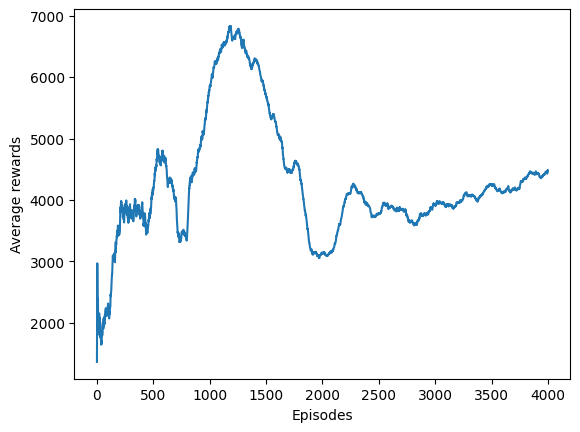

In [632]:
######################## SOLUCIÓN ###########################
def plot_rewards():
    plt.plot(agent.mean_training_rewards)
    plt.ylabel('Average rewards')
    plt.xlabel('Episodes')
    plt.show()

plot_rewards()

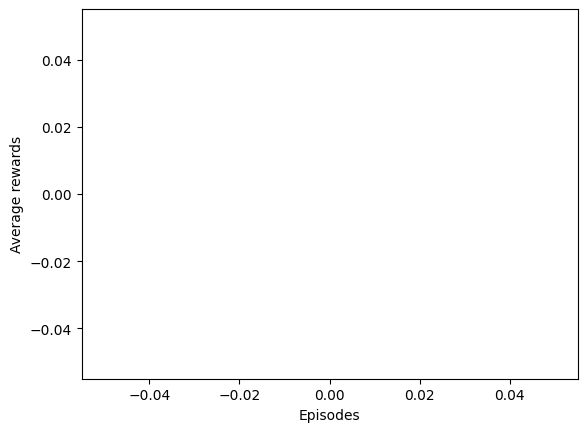

In [636]:
def plot_loss():
    plt.plot(agent.update_loss)
    plt.ylabel('Average rewards')
    plt.xlabel('Episodes')
    plt.show()

plot_loss()

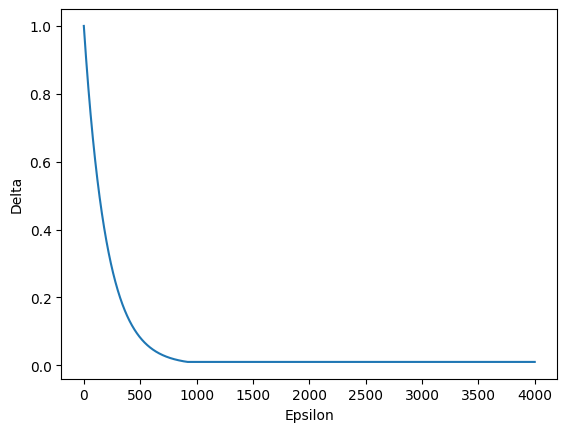

In [634]:
def plot_epsilon():
    plt.plot(agent.epsilon_history)
    plt.xlabel('Epsilon')
    plt.ylabel('Delta')
    plt.show()
    
plot_epsilon()

In [620]:
#TODO mostrar gráficas

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
Se observa que entre los 1000 y 1500 episodios la recompensa media obtiene los mejores valores, para posteriormente decaer bruscamente y sigue mejorando poco a poco hast aque finaliza el entrenamiento al alcanzar los 4000 episodios.

Epsilon decae bastante rápido y a partir de 1000 episodios se haya en su valor mínimo.
</div>

Una vez entrenado el agente, nos interesa comprobar cómo de bien ha aprendido y si es capaz de conseguir superar el entorno. Para ello, recuperamos el modelo entrenado y dejamos que el agente tome acciones aleatorias según ese modelo y observamos su comportamiento.

### 2.4 Test del agente.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0.25 ptos):</strong> Cargar el modelo entrenado y ejecutar el agente entrenado durante 505 episodios consecutivos en diferentes periodos aleatorios desde el año 2015 hasta el 2024. Calcula la suma de recompensas por cada ejecución. Para conseguir este punto, ejecuta:
    <ul>
        <li>Un gráfico con la suma de las recompensas respecto de los episodios, incluyendo el umbral de recompensa establecido</li>
        <li>Almacena la recompensa media obtenida en las 100 partidas en la variable <code>mean_reward_dqn_test</code> y la última recompensa obtenida en el entrenamiento en <code>mean_reward_dqn_last</code>. También obten en cuantos escenarios se ha obtenido más de 252 dias positivos en el trading. </li>
    </ul>
Además, realiza la siguiente análisis con el modelo para el entorno utilizado en el entrenamiento durante :
 <ul>
 <li>Reproducir una partida completa del agente entrenado y mostrar el resultado final, incluyendo el valor total del portafolio al final del episodio.</li>
        <li>Generar un fichero CSV que registre los resultados de las interacciones del agente con el mercado en cada episodio y muestra por pantalla las últimas 30 acciones.</li>
 </ul>
<strong>Comenta todos los resultados obtenidos en este apartado. ¿A qué conclusiones podemos llegar? ¿Cómo podríamos mejorar el entrenamiento y qué implicaciones tendría?</strong>


</div>



In [637]:
#Generar un fichero CSV que registre los resultados de las interacciones
#del agente con el mercado en cada episodio y muestra por pantalla las últimas 30 acciones.
file_path = 'stock_trading_agent_dqn.csv'
#Reproducir una partida completa del agente entrenado y mostrar el resultado final,
#incluyendo el valor total del portafolio al final del episodio.
env = StockMarketEnv(
    ticker='SPY',
    start="2015-01-01",
    end="2024-01-01",
    save_to_csv=True,
    csv_filename=file_path
)


def read_csv_and_show_last_30(file_path):
    try:
        df = pd.read_csv(env.csv_filename)
        print(f"\nLast 30 rows of {env.csv_filename}:")
        print(df.tail(30))

    except FileNotFoundError:
        print(f"El archivo {file_path} no fue encontrado.")
    except Exception as e:
        print(f"Se produjo un error al leer el archivo: {e}")

# Ejemplo de uso
read_csv_and_show_last_30(file_path)



[*********************100%***********************]  1 of 1 completed

El archivo stock_trading_agent_dqn.csv no fue encontrado.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Test Episode 1/100: Reward = 574.35, Positive Days = 125


[*********************100%***********************]  1 of 1 completed

Test Episode 2/100: Reward = 3300.01, Positive Days = 184


[*********************100%***********************]  1 of 1 completed

Test Episode 3/100: Reward = -1617.86, Positive Days = 58


[*********************100%***********************]  1 of 1 completed

Test Episode 4/100: Reward = 930.43, Positive Days = 52


[*********************100%***********************]  1 of 1 completed

Test Episode 5/100: Reward = 2396.89, Positive Days = 197


[*********************100%***********************]  1 of 1 completed

Test Episode 6/100: Reward = 2513.93, Positive Days = 168


[*********************100%***********************]  1 of 1 completed

Test Episode 7/100: Reward = -360.41, Positive Days = 87


[*********************100%***********************]  1 of 1 completed

Test Episode 8/100: Reward = 255.98, Positive Days = 40


[*********************100%***********************]  1 of 1 completed

Test Episode 9/100: Reward = 1611.81, Positive Days = 136


[*********************100%***********************]  1 of 1 completed

Test Episode 10/100: Reward = 665.27, Positive Days = 39


[*********************100%***********************]  1 of 1 completed

Test Episode 11/100: Reward = 2439.37, Positive Days = 193


[*********************100%***********************]  1 of 1 completed

Test Episode 12/100: Reward = 1225.20, Positive Days = 68


[*********************100%***********************]  1 of 1 completed

Test Episode 13/100: Reward = 1757.96, Positive Days = 145


[*********************100%***********************]  1 of 1 completed

Test Episode 14/100: Reward = 2099.04, Positive Days = 107


[*********************100%***********************]  1 of 1 completed

Test Episode 15/100: Reward = 668.10, Positive Days = 56


[*********************100%***********************]  1 of 1 completed

Test Episode 16/100: Reward = -1115.49, Positive Days = 153


[*********************100%***********************]  1 of 1 completed

Test Episode 17/100: Reward = 1153.57, Positive Days = 53


[*********************100%***********************]  1 of 1 completed

Test Episode 18/100: Reward = -1610.23, Positive Days = 60


[*********************100%***********************]  1 of 1 completed

Test Episode 19/100: Reward = 2079.73, Positive Days = 105


[*********************100%***********************]  1 of 1 completed

Test Episode 20/100: Reward = 3280.34, Positive Days = 137


[*********************100%***********************]  1 of 1 completed

Test Episode 21/100: Reward = 1086.11, Positive Days = 72


[*********************100%***********************]  1 of 1 completed

Test Episode 22/100: Reward = 2391.13, Positive Days = 73


[*********************100%***********************]  1 of 1 completed

Test Episode 23/100: Reward = 1981.52, Positive Days = 114


[*********************100%***********************]  1 of 1 completed

Test Episode 24/100: Reward = 702.69, Positive Days = 67


[*********************100%***********************]  1 of 1 completed

Test Episode 25/100: Reward = 2776.03, Positive Days = 64


[*********************100%***********************]  1 of 1 completed

Test Episode 26/100: Reward = -1647.00, Positive Days = 76


[*********************100%***********************]  1 of 1 completed

Test Episode 27/100: Reward = 2056.06, Positive Days = 117


[*********************100%***********************]  1 of 1 completed

Test Episode 28/100: Reward = 1130.73, Positive Days = 62


[*********************100%***********************]  1 of 1 completed

Test Episode 29/100: Reward = -1547.10, Positive Days = 55


[*********************100%***********************]  1 of 1 completed

Test Episode 30/100: Reward = 702.69, Positive Days = 67


[*********************100%***********************]  1 of 1 completed

Test Episode 31/100: Reward = 840.66, Positive Days = 64


[*********************100%***********************]  1 of 1 completed

Test Episode 32/100: Reward = -1537.59, Positive Days = 46


[*********************100%***********************]  1 of 1 completed

Test Episode 33/100: Reward = 697.96, Positive Days = 149


[*********************100%***********************]  1 of 1 completed

Test Episode 34/100: Reward = 915.07, Positive Days = 130


[*********************100%***********************]  1 of 1 completed

Test Episode 35/100: Reward = -946.89, Positive Days = 151


[*********************100%***********************]  1 of 1 completed

Test Episode 36/100: Reward = 1198.44, Positive Days = 56


[*********************100%***********************]  1 of 1 completed

Test Episode 37/100: Reward = 2415.01, Positive Days = 64


[*********************100%***********************]  1 of 1 completed

Test Episode 38/100: Reward = 2651.82, Positive Days = 169


[*********************100%***********************]  1 of 1 completed

Test Episode 39/100: Reward = 1995.49, Positive Days = 90


[*********************100%***********************]  1 of 1 completed

Test Episode 40/100: Reward = 2382.41, Positive Days = 93


[*********************100%***********************]  1 of 1 completed

Test Episode 41/100: Reward = -600.67, Positive Days = 138


[*********************100%***********************]  1 of 1 completed

Test Episode 42/100: Reward = 2636.34, Positive Days = 159


[*********************100%***********************]  1 of 1 completed

Test Episode 43/100: Reward = 1326.27, Positive Days = 51


[*********************100%***********************]  1 of 1 completed

Test Episode 44/100: Reward = -259.78, Positive Days = 155

Test Episode 45/100: Reward = 2733.96, Positive Days = 119

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Test Episode 46/100: Reward = 2154.76, Positive Days = 86


[*********************100%***********************]  1 of 1 completed

Test Episode 47/100: Reward = 4155.89, Positive Days = 130


[*********************100%***********************]  1 of 1 completed

Test Episode 48/100: Reward = 2661.15, Positive Days = 168


[*********************100%***********************]  1 of 1 completed

Test Episode 49/100: Reward = 779.04, Positive Days = 58


[*********************100%***********************]  1 of 1 completed

Test Episode 50/100: Reward = 3017.09, Positive Days = 155


[*********************100%***********************]  1 of 1 completed

Test Episode 51/100: Reward = 3368.25, Positive Days = 120


[*********************100%***********************]  1 of 1 completed

Test Episode 52/100: Reward = 4381.35, Positive Days = 188


[*********************100%***********************]  1 of 1 completed

Test Episode 53/100: Reward = -1667.55, Positive Days = 28

Test Episode 54/100: Reward = 1632.97, Positive Days = 180

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Test Episode 55/100: Reward = 835.58, Positive Days = 60


[*********************100%***********************]  1 of 1 completed

Test Episode 56/100: Reward = 1522.91, Positive Days = 116


[*********************100%***********************]  1 of 1 completed

Test Episode 57/100: Reward = 2317.08, Positive Days = 105


[*********************100%***********************]  1 of 1 completed

Test Episode 58/100: Reward = -595.38, Positive Days = 163

Test Episode 59/100: Reward = 863.35, Positive Days = 68

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Test Episode 60/100: Reward = 975.70, Positive Days = 126


[*********************100%***********************]  1 of 1 completed

Test Episode 61/100: Reward = 2001.62, Positive Days = 96


[*********************100%***********************]  1 of 1 completed

Test Episode 62/100: Reward = -936.23, Positive Days = 110


[*********************100%***********************]  1 of 1 completed

Test Episode 63/100: Reward = 4986.96, Positive Days = 140


[*********************100%***********************]  1 of 1 completed

Test Episode 64/100: Reward = 2068.92, Positive Days = 120


[*********************100%***********************]  1 of 1 completed

Test Episode 65/100: Reward = -420.49, Positive Days = 158


[*********************100%***********************]  1 of 1 completed

Test Episode 66/100: Reward = 835.46, Positive Days = 65


[*********************100%***********************]  1 of 1 completed

Test Episode 67/100: Reward = 2485.75, Positive Days = 190


[*********************100%***********************]  1 of 1 completed

Test Episode 68/100: Reward = -1575.82, Positive Days = 5


[*********************100%***********************]  1 of 1 completed

Test Episode 69/100: Reward = -1539.45, Positive Days = 59


[*********************100%***********************]  1 of 1 completed

Test Episode 70/100: Reward = 4523.12, Positive Days = 112


[*********************100%***********************]  1 of 1 completed

Test Episode 71/100: Reward = -201.76, Positive Days = 162


[*********************100%***********************]  1 of 1 completed

Test Episode 72/100: Reward = -1707.20, Positive Days = 40


[*********************100%***********************]  1 of 1 completed

Test Episode 73/100: Reward = 1877.33, Positive Days = 170


[*********************100%***********************]  1 of 1 completed

Test Episode 74/100: Reward = 741.87, Positive Days = 45


[*********************100%***********************]  1 of 1 completed

Test Episode 75/100: Reward = 2525.53, Positive Days = 166


[*********************100%***********************]  1 of 1 completed

Test Episode 76/100: Reward = -1519.51, Positive Days = 58


[*********************100%***********************]  1 of 1 completed

Test Episode 77/100: Reward = 604.70, Positive Days = 56


[*********************100%***********************]  1 of 1 completed

Test Episode 78/100: Reward = 1193.20, Positive Days = 62


[*********************100%***********************]  1 of 1 completed

Test Episode 79/100: Reward = 4291.60, Positive Days = 120


[*********************100%***********************]  1 of 1 completed

Test Episode 80/100: Reward = 2674.97, Positive Days = 148


[*********************100%***********************]  1 of 1 completed

Test Episode 81/100: Reward = 986.42, Positive Days = 73

Test Episode 82/100: Reward = 884.04, Positive Days = 164

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Test Episode 83/100: Reward = -155.49, Positive Days = 62


[*********************100%***********************]  1 of 1 completed

Test Episode 84/100: Reward = -1503.21, Positive Days = 38


[*********************100%***********************]  1 of 1 completed

Test Episode 85/100: Reward = -1611.65, Positive Days = 27


[*********************100%***********************]  1 of 1 completed

Test Episode 86/100: Reward = 2291.00, Positive Days = 104


[*********************100%***********************]  1 of 1 completed

Test Episode 87/100: Reward = 2231.45, Positive Days = 106


[*********************100%***********************]  1 of 1 completed

Test Episode 88/100: Reward = 3755.91, Positive Days = 151


[*********************100%***********************]  1 of 1 completed

Test Episode 89/100: Reward = 3287.81, Positive Days = 130


[*********************100%***********************]  1 of 1 completed

Test Episode 90/100: Reward = -563.62, Positive Days = 85


[*********************100%***********************]  1 of 1 completed

Test Episode 91/100: Reward = 1158.08, Positive Days = 64


[*********************100%***********************]  1 of 1 completed

Test Episode 92/100: Reward = 1713.35, Positive Days = 106


[*********************100%***********************]  1 of 1 completed

Test Episode 93/100: Reward = -1789.89, Positive Days = 60


[*********************100%***********************]  1 of 1 completed

Test Episode 94/100: Reward = 2300.77, Positive Days = 187


[*********************100%***********************]  1 of 1 completed

Test Episode 95/100: Reward = -496.24, Positive Days = 158

Test Episode 96/100: Reward = 2541.29, Positive Days = 182

[*********************100%***********************]  1 of 1 completed


Test Episode 97/100: Reward = 1076.31, Positive Days = 55

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Test Episode 98/100: Reward = 1234.68, Positive Days = 72


[*********************100%***********************]  1 of 1 completed

Test Episode 99/100: Reward = 2590.58, Positive Days = 184

Test Episode 100/100: Reward = 3158.56, Positive Days = 185

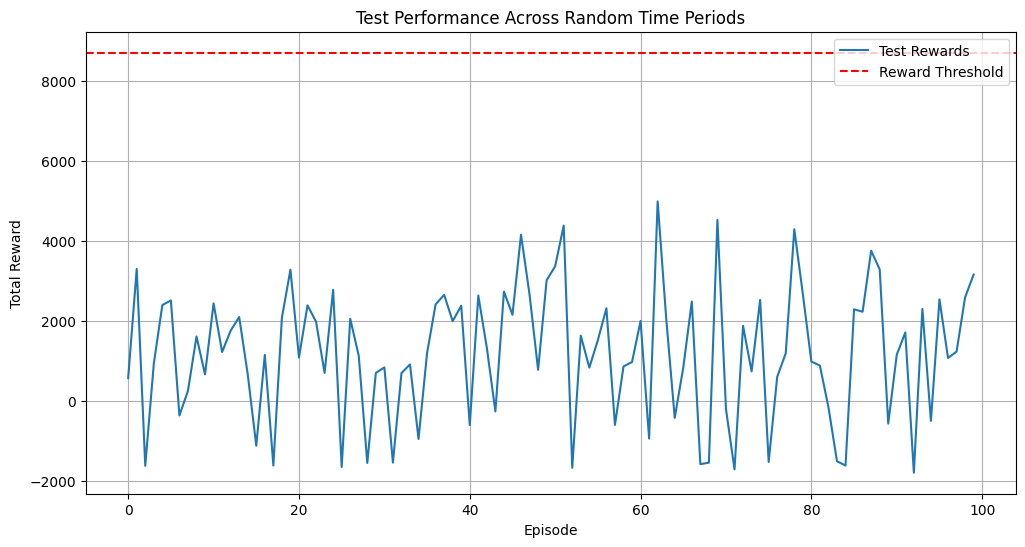

In [641]:
import random
import pandas as pd
import numpy as np

# Generar calendario de trading usando días hábiles
def generate_random_trading_dates(start_range, end_range, trading_days_target=505):
    """
    Genera un par de fechas (start, end) que tengan exactamente trading_days_target días hábiles.
    """
    start_date = pd.to_datetime(start_range)
    end_date = pd.to_datetime(end_range)

    while True:
        # Seleccionar una fecha de inicio aleatoria
        random_start = start_date + pd.DateOffset(days=random.randint(0, (end_date - start_date).days - trading_days_target))

        # Generar un rango de fechas de trading usando solo los días hábiles
        trading_days = pd.bdate_range(random_start, random_start + pd.DateOffset(days=2 * trading_days_target)).tolist()

        # Filtrar las fechas para obtener exactamente el número de días objetivo
        if len(trading_days) >= trading_days_target:
            random_end = trading_days[trading_days_target - 1]  # Último día de trading en el rango deseado
            return random_start.strftime("%Y-%m-%d"), random_end.strftime("%Y-%m-%d")

def test_model(ag, base_env, start_range, end_range, trading_days_target=505, win_days_target=252):
    all_rewards = []
    win_days_count = []
    
    for i_episode in range(100):
        # Generate random start and end dates
        start_date, end_date = generate_random_trading_dates(start_range, end_range, trading_days_target)
        
        # Create new environment with random dates
        env = StockMarketEnv(
            ticker='SPY',
            start=start_date,
            end=end_date,
            save_to_csv=True,
            csv_filename=file_path
        )
        
        # Reset environment and initialize variables
        state = env.reset()[0]
        episode_reward = 0
        positive_days = 0
        done = False
        
        # Run episode
        while not done:
            # Get action from trained agent
            action = ag.main_network.get_action(state, epsilon=0.01)  # Small epsilon for some exploration
            
            # Take step in environment
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            # Update state and accumulate reward
            state = next_state
            episode_reward += reward
            
            # Count positive days (when reward > 0)
            if reward > 0:
                positive_days += 1
        
        # Store results
        all_rewards.append(episode_reward)
        win_days_count.append(positive_days)
        
        # Print progress
        print(f"\rTest Episode {i_episode + 1}/100: Reward = {episode_reward:.2f}, Positive Days = {positive_days}", end="")
        
        env.close()

    success_rate = sum(days >= win_days_target for days in win_days_count) / len(win_days_count)
    
    return all_rewards, success_rate
        
dqn_agent = deepcopy(agent)

test_rewards, success_rate = test_model(
    agent, 
    env,
    start_range="2015-01-01",
    end_range="2024-01-01",
    trading_days_target=505,
    win_days_target=252
)

def plot_test(rewards, th):
    plt.figure(figsize=(12, 6))
    plt.plot(rewards, label='Test Rewards')
    plt.axhline(y=th, color='r', linestyle='--', label='Reward Threshold')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Test Performance Across Random Time Periods')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# Store metrics
mean_reward_dqn = np.mean(test_rewards)
mean_reward_dqn_last = agent.mean_training_rewards[-1]

# Plot results
plot_test(test_rewards, REWARD_THRESHOLD)

In [642]:
print(f"\nTest Results:")
print(f"La recompensa media obtenida por el agente DQN en las 100 partidas de test es:: {mean_reward_dqn:.2f} puntos.")
print(f"Reward final: {mean_reward_dqn_last:.2f}")
print(f"Porcentaje de episodios que lograron ganar al menos 252 días: {success_rate*100:.2f}%")

print("\nUltimas 30 entradas:")
read_csv_and_show_last_30('stock_trading_agent_dqn.csv')



Test Results:
La recompensa media obtenida por el agente DQN en las 100 partidas de test es:: 1207.32 puntos.
Reward final: 4480.35
Porcentaje de episodios que lograron ganar al menos 252 días: 0.00%

Ultimas 30 entradas:

Last 30 rows of stock_trading_agent_dqn.csv:
        Step     Balance  Shares Held   Net Worth     Profit
133798   455 10465.44000      0.00000 10465.44000  465.44000
133799   456 10465.44000      0.00000 10465.44000  465.44000
133800   457 10465.44000      0.00000 10465.44000  465.44000
133801   458 10465.44000      0.00000 10465.44000  465.44000
133802   459 10465.44000      0.00000 10465.44000  465.44000
133803   460 10465.44000      0.00000 10465.44000  465.44000
133804   461 10465.44000      0.00000 10465.44000  465.44000
133805   462 10465.44000      0.00000 10465.44000  465.44000
133806   463 10465.44000      0.00000 10465.44000  465.44000
133807   464 10465.44000      0.00000 10465.44000  465.44000
133808   465 10465.44000      0.00000 10465.44000  465.44000


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
#TODO







</div>

## 3. Agente Dueling DQN (1.5 ptos)

En este apartado resolveremos el mismo entorno con las mismas características para el agente, pero usando una dueling DQN. Como en el caso anterior, primero definiremos el modelo de red neuronal, luego describiremos el comportamiento del agente, lo entrenaremos y, finalmente, testearemos el funcionamiento del agente entrenado.



### 3.1 Definición de la arquitectura  de la red neuronal


El objetivo principal de las dueling DQN es "ahorrarse" el cálculo del valor de Q en aquéllos estados en los que es irrelevante la acción que se tome. Para ello se descompone la función Q en dos componentes:


$$Q(s, a) = A(s, a) + V (s)$$


Esta descomposición se realiza a nivel de la arquitectura de la red neuronal. Las primeras capas que teníamos en la DQN serán comunes, y luego la red se dividirá en dos partes separadas definidas por el resto de capas.


La descomposición en sub-redes del modelo de la DQN implementada en el apartado anterior, será entonces:

<ol> <li> Bloque común: </li> <ul> <li>Una primera capa completamente conectada de 256 neuronas y <code>bias = True</code>, con activación ReLU </li
<li>Una primera capa completamente conectada de 128 neuronas y <code>bias = True</code>, con activación ReLU </li

> </ul> <li>Para cada una de las subredes de ventaja A(s,a) y valor V(s):</li> <ul> <li>Una capa completamente conectada de 64 neuronas y <code>bias = True</code>, con activación ReLU </li> <li>Una última capa completamente conectada y <code>bias = True</code>. Esta será nuestra capa de salida y por tanto el número de neuronas de salida dependerá de si se trata de la red A(s,a), que tendrá tantas neuronas como dimensiones tenga el espacio de acciones, o si se trata de la red V(s), con un valor por estado.</li> </ul> </ol>

     


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 3.1 (0.5 ptos):</strong> Implementar la clase <code>duelingDQN()</code>. Inicializar las variables necesarias y definir el modelo de red neuronal indicado.

    -----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se os proporciona el código pre-implementado. La implementación que se pide en el enunciado está indicada en los bloques <i>#TODO</i> y/o con variables igualadas a <i>None</i>.
</div>


In [652]:
import torch.autograd as autograd

class duelingDQN(torch.nn.Module):

    def __init__(self, env, device=None, learning_rate=1e-3):

        """
        Parámetros
        ==========
        n_inputs: tamaño del espacio de estados
        n_outputs: tamaño del espacio de acciones
        actions: array de acciones posibles
        """

        ###################################
        ####TODO: Inicializar variables####
        super(duelingDQN, self).__init__()
        self.device = torch.device("mps")

        self.n_inputs = env.observation_space.shape[0]
        self.n_outputs = env.action_space.n
        self.actions = np.arange(self.n_outputs)
        self.learning_rate = learning_rate

        ######

        #######################################
        ##TODO: Construcción de la red neuronal
        # Red común
        ##Construcción de la red neuronal
        self.model_common = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 256, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128, bias=True),
            torch.nn.ReLU()
        ).to(self.device)

        self.fc_layer_inputs = self.feature_size()

        # Subred de la Ventaja A(s,a)
        self.advantage = torch.nn.Sequential(
            torch.nn.Linear(self.fc_layer_inputs, 64, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(64, self.n_outputs, bias=True)
        ).to(self.device)

        # Subred de la función de Valor
        self.value = self.value = torch.nn.Sequential(
            torch.nn.Linear(self.fc_layer_inputs, 64, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1, bias=True)
        ).to(self.device)

        #######
        #######################################
        ##TODO: Inicializar el optimizador
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    #######################################
    #####TODO: función forward#############
    def forward(self, state):
        # Conexión entre capas de la red común
        common_out = self.model_common(state)

        # Conexión entre capas de la Subred de Valor
        advantage = self.advantage(common_out)
        # Conexión entre capas de la Subred de Ventaja
        value = self.value(common_out)

        ## Agregar las dos subredes:
        # Q(s,a) = V(s) + (A(s,a) - 1/|A| * sum A(s,a'))
        action = value + (advantage - advantage.mean(dim=0, keepdim=True))

        return action
    #######

    ### MéTODO e-greedy
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions)
        else:
            qvals = self.get_qvals(state)
            action = torch.max(qvals, dim=-1)[1].item()
        return action


    def get_qvals(self, state):
        if type(state) is tuple:
            state = np.array([np.ravel(s) for s in state])
        state_t = torch.FloatTensor(state).to(self.device)
        return self.forward(state_t)

    def feature_size(self):
        dummy_input = torch.zeros(1, *env.observation_space.shape).to(self.device)
        return self.model_common(autograd.Variable(dummy_input)).view(1, -1).size(1)


Para el buffer de repetición de experiencias podemos usar exactamente la misma clase experienceReplayBuffer descrita en el apartado anterior de la DQN.


### 3.2 Definición del agente

La diferencia entre la DQN y la dueling DQN se centra, como hemos visto, en la definición de la arquitectura de la red. Pero el proceso de aprendizaje y actualización es exactamente el mismo. Así, podemos recuperar la clase implementada en el apartado anterior, DQNAgent() y reutilizarla aquí bajo el nombre de duelingDQNAgent(). Lo único que deberemos hacer es añadir el optimizador entre las variables a declarar y adaptar la función de pérdida al formato Functional de pytorch.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 3.2 (0.25 pto):</strong> Implementar la clase <code>duelingDQNAgent()</code> como la <code>DQNAgent()</code>
<p>
</p>
De nuevo, durante el proceso se deben almacenar (*):
    <ul>
        <li>Las recompensas obtenidas en cada paso del entrenamiento</li>
        <li>Las recompensas medias de los 100 episodios anteriores</li>
        <li>La pérdida durante el entrenamiento</li>
        <li>La evolución de epsilon a lo largo del entrenamiento</li>
    </ul>

    -----------------------------------------------------------------------------------------------------------
<b>Nota</b>: se os proporciona el código pre-implementado. La implementación que se pide en el enunciado está indicada en los bloques <i>#TODO</i> y/o con variables igualadas a <i>None</i>, salvo (*) en qué momento almacenar las variables que se indican.

In [644]:
class duelingDQNAgent:

    def __init__(self, env, main_network, buffer, reward_threshold, epsilon=0.1, eps_decay=0.99, batch_size=32, device= None):
        """"
        Params
        ======
        env: entorno
        target_network: clase con la red neuronal diseñada
        target_network: red objetivo
        buffer: clase con el buffer de repetición de experiencias
        epsilon: epsilon
        eps_decay: epsilon decay
        batch_size: batch size
        nblock: bloque de los X últimos episodios de los que se calculará la media de recompensa
        reward_threshold: umbral de recompensa definido en el entorno
        """
        self.device = torch.device("mps")
        ###############################################################
        #####TODO 1: inicialitzar variables######

        self.env = env
        self.main_network = main_network
        self.target_network = deepcopy(main_network)
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.nblock = 100 
        self.reward_threshold = reward_threshold

        self.initialize()


    ###############################################################
    #####TODO 2: inicialitzar variables extra que se necessiten######
    def initialize(self):
        self.training_rewards = []      
        self.mean_training_rewards = []
        self.update_loss = []
        self.epsilon_history = []
        
        self.total_reward = 0
        self.step_count = 0
        self.state0 = self.env.reset()[0]
        self.episodes_train_dqn = 0



    #################################################################################
    ######TODO 3:  Tomar nueva acción ###############################################
    def take_step(self, eps, mode='train'):
        if mode == 'explore':
            action = self.env.action_space.sample()
        else:
            action = self.main_network.get_action(self.state0, eps)  # TODO  acción a partir del valor de Q (elección de la acción con mejor Q)
            self.step_count += 1

        #TODO: Realización de la acción y obtención del nuevo estado y la recompensa
        next_state, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        
        self.buffer.append(self.state0, action, reward, done, next_state)
        
        self.state0 = next_state
        self.total_reward += reward
        #TODO: resetear entorno 'if done'
        if done:
            self.training_rewards.append(self.total_reward)
            self.state0 = self.env.reset()[0]
            self.total_reward = 0
        return done

    ## Entrenamiento
    def train(self, gamma=0.99, max_episodes=50000,
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000, min_episodios=250):
        self.gamma = gamma
        # Rellenamos el buffer con N experiencias aleatorias ()
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')

        episode = 0
        training = True
        print("Training...")
        while training:
            self.state0 = self.env.reset()[0]
            self.total_reward = 0
            gamedone = False
            while gamedone == False:
                # El agente toma una acción
                gamedone = self.take_step(self.epsilon, mode='train')

                #################################################################################
                #####TODO 4: Actualizar la red principal según la frecuencia establecida  #######
                if self.step_count % dnn_update_frequency == 0:
                    self.update()

                ########################################################################################
                ###TODO6: Sincronizar red principal y red objetivo según la frecuencia establecida#####
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(self.main_network.state_dict())

                if gamedone:
                    episode += 1
                    ##################################################################
                    ########TODO: Almacenar epsilon, training rewards i loss#######

                    ####
                    self.update_loss = []

                    #######################################################################################
                    ###TODO 7: calcular la media de recompensa de los últimos X episodios, y almacenar#####
                    ###
                    self.episodes_train_dqn = episode
                    
                    # Store metrics (*)
                    mean_rewards = np.mean(self.training_rewards[-self.nblock:])
                    self.mean_training_rewards.append(mean_rewards)
                    self.epsilon_history.append(self.epsilon)
                    
                    print(f"\rEpisode {episode} Mean Rewards {mean_rewards:.2f} Epsilon {self.epsilon}\t\t", end="")

                    print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {}\t\t".format(
                        episode, mean_rewards, self.epsilon), end="")

                    # Comprobar si se ha llegado al máximo de episodios
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached.')
                        break

                    # Termina el juego si la media de recompensas ha llegado al umbral fijado para este juego
                    # y se ha entrenado un mínimo de episodios
                    if mean_rewards >= self.reward_threshold and min_episodios < episode:
                        training = False
                        print('\nEnvironment solved in {} episodes!'.format(episode))
                        break

                    #################################################################################
                    ######TODO 8: Actualizar epsilon ########
                    self.epsilon = max(self.epsilon * self.eps_decay, 0.01)
                    
     ## Cálculo de la pérdida
    def calculate_loss(self, batch):
        # Separamos las variables de la experiencia y las convertimos a tensores
        states, actions, rewards, dones, next_states = [i for i in batch]
        rewards_vals = torch.FloatTensor(rewards).to(self.device).reshape(-1,1)
        actions_vals = torch.LongTensor(np.array(actions)).reshape(-1,1).to(self.device)
        dones_t = torch.ByteTensor(dones).to(self.device)

        # Obtenemos los valores de Q de la red principal
        qvals = torch.gather(self.main_network.get_qvals(states).to(self.device), 1, actions_vals)

        #update#
        next_actions = torch.max(self.main_network.get_qvals(next_states).to(self.device), dim=-1)[1]
        next_actions_vals = next_actions.reshape(-1, 1).to(self.device)


        # Obtenemos los valores de Q de la red objetivo
        target_qvals = self.target_network.get_qvals(next_states).to(self.device)
        qvals_next = torch.gather(target_qvals, 1, next_actions_vals).detach()
        #####
        qvals_next[dones_t.bool()] = 0
        #qvals_next[dones_t] = 0 # 0 en estados terminales
        # Calculamos ecuación de Bellman
        expected_qvals = rewards_vals + self.gamma * qvals_next
        #Función Loss #####
        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1,1))
        self.update_loss.append(loss.item())
        #######
        return loss

    def update(self):
        self.main_network.optimizer.zero_grad()  # eliminamos cualquier gradiente pasado
        batch = self.buffer.sample_batch(batch_size=self.batch_size) # seleccionamos un conjunto del buffer
        loss = self.calculate_loss(batch) # calculamos la pérdida
        loss.backward() # hacemos la diferencia para obtener los gradientes
        self.main_network.optimizer.step() # aplicamos los gradientes a la red neuronal
        # Guardamos los valores de pérdida
        if self.device.type == 'mps':
            loss_value = loss.detach().to('cpu').item()
        else:
            loss_value = loss.detach().cpu().numpy()
        self.update_loss.append(loss_value)


### 3.3 Entrenamiento del Modelo

A continuación entrenaremos el modelo dueling DQN con los mismos hiperparámetros con los que entrenamos la DQN.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 3.3 (0.25 ptos):</strong> Cargar el modelo de red neuronal y entrenar el agente con los mismos hiperparámetros usados para la DQN
</div>


In [ ]:
#TODO Tiempo ejecución 69 mintuos en google colaboratory con GPU.
#resultado esperado alrededor de 180-200 puntos.
LEARNING_RATE = 0.0005
BATCH_SIZE = 128
MAX_EPISODES = 4000
BURN_IN = 1000
UPDATE_FREQ = 6
SYNC_FREQ = 15
MEMORY_SIZE = 50000
GAMMA = 0.99
EPSILON = 1.0
EPSILON_DECAY = 0.995

# Calculate REWARD_THRESHOLD
ticker = 'SPY'
start = '2019-01-01'
end = '2021-01-01'

# Download data to get number of trading days
temp_data = yf.download(ticker, start, end)
num_days = len(temp_data)
print(f"Numero de dias de trading para {ticker} desde {start} hasta {end}: {num_days}")
print(f"Nuestro objetivo ganar el 50 por ciento de los dias: {round(num_days/2)}")
REWARD_THRESHOLD = 8400

# Training
print("Starting training...")
start_time = time.time()

# Create environment
dueling_env = StockMarketEnv(ticker=ticker, start=start, end=end)

# Create experience replay buffer
buffer_dueling = experienceReplayBuffer(memory_size=MEMORY_SIZE, burn_in=BURN_IN)

# Create neural network
dueling_main_network = duelingDQN(
    env=dueling_env,
    learning_rate=LEARNING_RATE
)

# Create DQN agent
dueling_agent = duelingDQNAgent(
    env=dueling_env,
    main_network=dueling_main_network,
    buffer=buffer_dueling,
    epsilon=EPSILON,
    eps_decay=EPSILON_DECAY,
    batch_size=BATCH_SIZE,
    reward_threshold=REWARD_THRESHOLD,
)

# Train the agent
dueling_agent.train(
    gamma=GAMMA,
    max_episodes=MAX_EPISODES,
    batch_size=BATCH_SIZE,
    dnn_update_frequency=UPDATE_FREQ,
    dnn_sync_frequency=SYNC_FREQ,
    min_episodios=300,
)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Numero de dias de trading para SPY desde 2019-01-01 hasta 2021-01-01: 505
Nuestro objetivo ganar el 50 por ciento de los dias: 252
Starting training...
Filling replay buffer...
Training...
Episode 77 Mean Rewards 1684.03 Epsilon 0.6832098777212641		

### 3.4 Análisis del entrenamiento

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 3.4 (0.25 ptos):</strong> Mostrar los mismos gráficos que con la DQN:
    <ol>
        <li>Recompensas obtenidas a lo largo del entrenamieno y la evolución de las recompensas medias cada 100 episodios, junto con el umbral de recompensa establecido por el entorno</li>
        <li>Pérdida durante el entrenamiento</li>
        <li>Evolución de epsilon a lo largo del entrenamiento</li>
    </ol>
</div>

### 3.5 Test del agente.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (0.25 ptos):</strong> Cargar el modelo entrenado y ejecutar el agente entrenado durante 505 episodios consecutivos en diferentes periodos aleatorios desde el año 2015 hasta el 2024. Calcula la suma de recompensas por cada ejecución. Para conseguir este punto, ejecuta:
    <ul>
        <li>Un gráfico con la suma de las recompensas respecto de los episodios, incluyendo el umbral de recompensa establecido</li>
        <li>Almacena la recompensa media obtenida en las 100 partidas en la variable <code>mean_reward_agentduelingDQN</code> y la última recompensa obtenida en el entrenamiento en <code>mean_reward_agentduelingDQN_last</code></li>
    </ul>
Además, realiza la siguiente análisis con el modelo para el entorno utilizado en el entrenamiento durante :
 <ul>
 <li>Reproducir una partida completa del agente entrenado y mostrar el resultado final, incluyendo el valor total del portafolio al final del episodio.</li>
        <li>Generar un fichero CSV que registre los resultados de las interacciones del agente con el mercado en cada episodio y muestra por pantalla las últimas 30 acciones.</li>
 </ul>
<strong>Comenta TODOs los resultados obtenidos en este apartado. ¿A qué conclusiones podemos llegar? ¿Cómo podríamos mejorar el entrenamiento y qué implicaciones tendría?</strong>


</div>




In [ ]:
file_path =  "stock_trading_agent_ddqn.csv"
env = None #TODO



mean_reward_agentduelingDQN = 0 #TODO
mean_reward_agentduelingDQN_last = 0 #TODO
print(f"La recompensa media obtenida por el agente DQN en las 100 partidas de test es: {mean_reward_agentduelingDQN:.2f} puntos.")





## 4.Comparación de los resultados (1.5 pto.)

Ahora vamos a comparar los resultados, si has seguido todas las indicaciones, habrás almacenado métricas bastante interesantes que te permitirán interpretar los resultados obtenidos.

In [ ]:

# Define los datos de la tabla
data = [
    ["DQN", mean_reward_dqn_last, mean_reward_dqn, time_dqn],
    ["Dueling DQN", mean_reward_agentduelingDQN_last, mean_reward_agentduelingDQN, time_ddqn],
]

# Define los encabezados de la tabla
headers = ["Agente", "Media Reward de Entrenamiento", "Media test con 100 Partidas Aleatorias" , "Tiempo entrenamiento."]

# Imprime la tabla
table = tabulate(data, headers, tablefmt="pipe")
print(table)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (1.5 ptos):</strong>

Comentar los resultados obtenidos. ¿Qué agente a obtenido mejor resultados? Justificalo.
    
</div>


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentario:</strong>
<br><br>
</div>

## 5. Compara los agentes en otro entorno.  (2 ptos)

En esta parte de la PEC vamos a comparar cómo se desenvuelven dichos agentes en otro entorno diferente implementado por un tercero.

Uno de los beneficios de haber utilizado Gymnasium es que podemos rápidamente utilizar nuestros algoritmos en todo aquel entorno que comparta la misma interfaz. Un ejemplo puede se [Cart Pole](https://gymnasium.farama.org/environments/classic_control/cart_pole/), un entorno clásico que consiste en un carrito sobre el que se apoya una barra vertical. El objetivo es mantener la barra en equilibrio evitando que caiga, aplicando pequeñas fuerzas al carrito hacia la derecha o hacia la izquierda. Las únicas acciones posibles son estas fuerzas, que permiten al algoritmo aprender a mantener el equilibrio de la barra en la posición correcta.

![cartpole](https://gymnasium.farama.org/_images/cart_pole.gif)


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio (2 ptos):</strong>

Ejecuta el agente DQN y Dueling DQN en el nuevo entorno. Una vez lo hayar realizado, implementar una tabla como la mostrar en el ejercico anterior y análiza los resultados. ¿Contínua siendo el mismo agente el que mejor resultado ha obtenido?
</div>

In [ ]:



# Configuración de hiperparámetros para dqn.
lr = None             # Velocidad de aprendizaje ajustada para mejor convergencia
MEMORY_SIZE = None     # Capacidad de memoria reducida, suficiente para un entorno simple como CartPole
MAX_EPISODES = 5000     # Número máximo de episodios reducido, ya que CartPole es un problema más sencillo
EPSILON = None             # Valor inicial de epsilon (alta exploración inicial)
EPSILON_DECAY = None    # Decaimiento de epsilon ajustado para un descenso más gradual
GAMMA = None           # Factor de descuento gamma l
BATCH_SIZE = None         # Tamaño del lote para el entrenamiento
BURN_IN = None           # Episodios iniciales para llenar el buffer de experiencia antes de entrenar
DNN_UPD = 1             # Frecuencia de actualización de la red neuronal (cada paso)
DNN_SYNC = 1000         # Frecuencia de sincronización de pesos






In [ ]:
from tqdm import tqdm

def test_model(ag, env):
    all_rewards = []
    # Usamos tqdm para el bucle de episodios
    for i_episode in tqdm(range(100), desc="Progreso de episodios"):
        #rodo
        pass

    return all_rewards



def plot_test(rewards, th):
    #TODO
    pass

In [ ]:
#utiliza las funciones anteriores para imprimir la evolución de los agenetes.

In [ ]:

# Muestras los datos de los entrenamientos de cada agente.
data = [
    ["DQN", mean_reward_dqn_last, mean_reward_dqn, time_dqn],
    ["Dueling DQN", mean_reward_agentduelingDQN_last, mean_reward_agentduelingDQN, time_ddqn],
]

# Define los encabezados de la tabla
headers = ["Agente", "Media Reward de Entrenamiento", "Media test con 100 Partidas Aleatorias" , "Tiempo entrenamiento."]

# Imprime la tabla
table = tabulate(data, headers, tablefmt="pipe")
print(table)